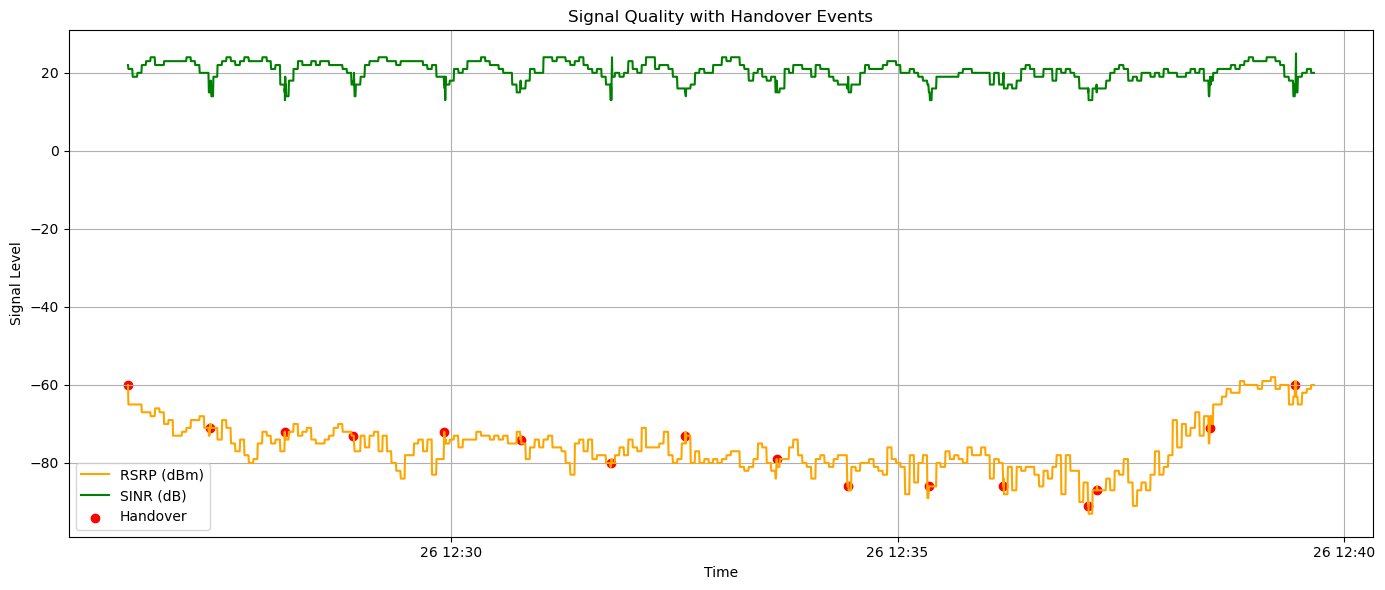

Total distance traveled: 6507.58 meters


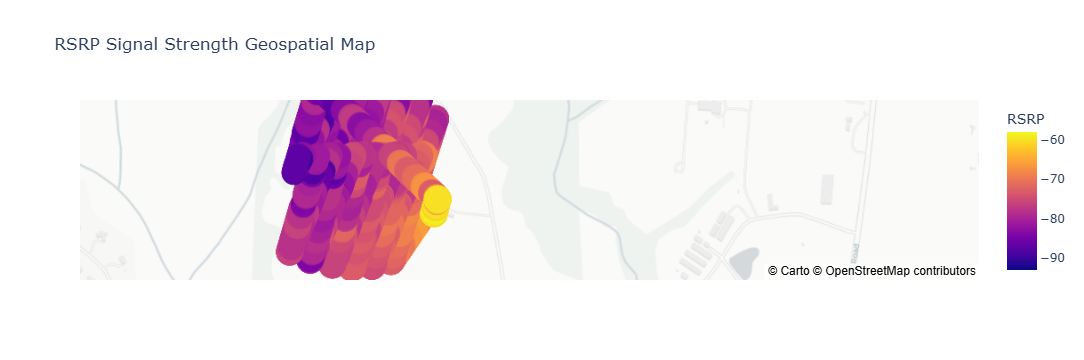

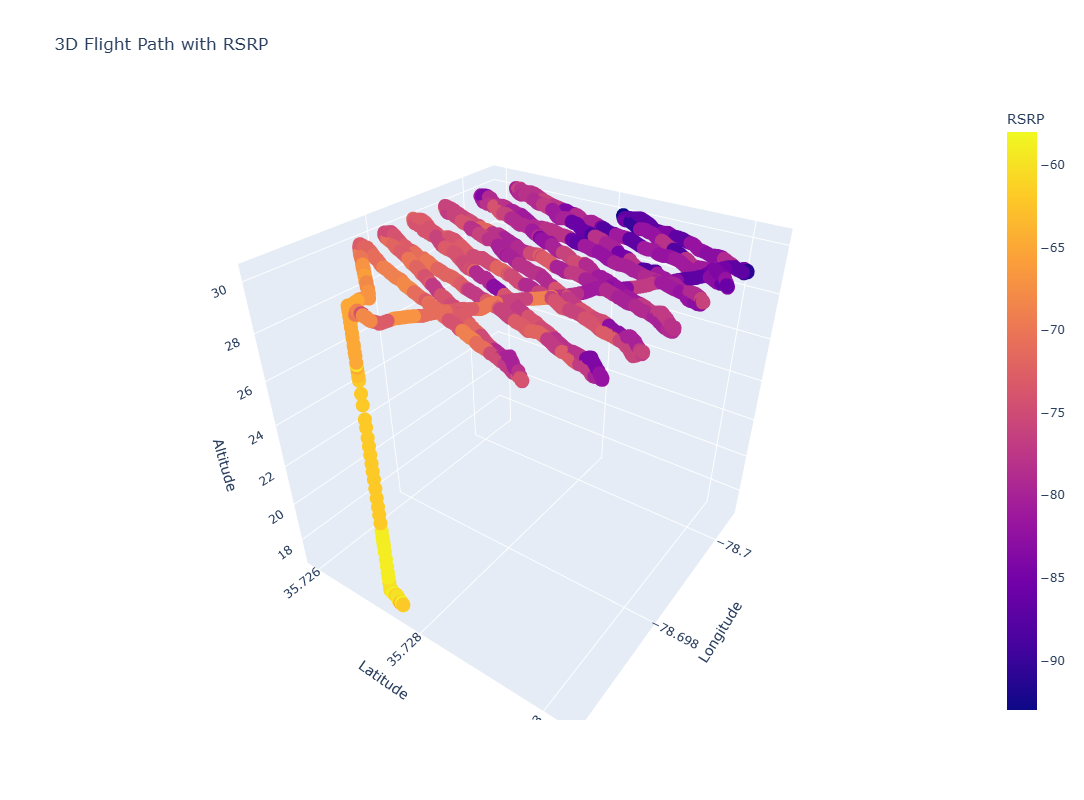

In [4]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import TimestampedGeoJson
import plotly.express as px
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Load and clean dataset
df = pd.read_csv("new_pro.csv")
df.columns = df.columns.str.strip()  # Remove whitespace

# Rename for consistency
df.rename(columns={
    "Time and date": "Time",
    "LTE RSRP": "RSRP",
    "LTE SINR": "SINR",
    "LTE Cell ID": "CellID"
}, inplace=True)

# Select relevant columns
cols_needed = ['Time', 'Latitude', 'Longitude', 'Altitude', 'RSRP', 'SINR', 'CellID']
df = df[[col for col in cols_needed if col in df.columns]].dropna()
df['Time'] = pd.to_datetime(df['Time'])
df.sort_values('Time', inplace=True)

# Mark handovers
df['Handover'] = df['CellID'].ne(df['CellID'].shift()).astype(int)

# Plot signal quality with handover markers
plt.figure(figsize=(14, 6))
plt.plot(df['Time'], df['RSRP'], label='RSRP (dBm)', color='orange')
plt.plot(df['Time'], df['SINR'], label='SINR (dB)', color='green')
plt.scatter(df['Time'][df['Handover']==1], df['RSRP'][df['Handover']==1], color='red', label='Handover')
plt.legend()
plt.title("Signal Quality with Handover Events")
plt.xlabel("Time")
plt.ylabel("Signal Level")
plt.grid(True)
plt.tight_layout()
plt.show()

# Interactive handover map
handover_points = df[df['Handover'] == 1]
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
map_ = folium.Map(location=map_center, zoom_start=15)

for _, row in handover_points.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Handover\nTime: {row['Time']}\nCell: {row['CellID']}",
        icon=folium.Icon(color='red')
    ).add_to(map_)

map_.save("handover_map.html")

# Movement animation + distance
features = []
total_distance = 0
for i in range(1, len(df)):
    prev = (df.iloc[i-1]['Latitude'], df.iloc[i-1]['Longitude'])
    curr = (df.iloc[i]['Latitude'], df.iloc[i]['Longitude'])
    total_distance += geodesic(prev, curr).meters

    features.append({
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [df.iloc[i]['Longitude'], df.iloc[i]['Latitude']]
        },
        'properties': {
            'time': df.iloc[i]['Time'].isoformat(),
            'style': {'color': 'blue'},
            'icon': 'circle',
            'popup': f"Alt: {df.iloc[i]['Altitude']:.1f} m"
        }
    })

movement_map = folium.Map(location=map_center, zoom_start=15)
TimestampedGeoJson({"type": "FeatureCollection", "features": features},
                   period="PT1S", add_last_point=True).add_to(movement_map)
movement_map.save("movement_animation.html")
print(f"Total distance traveled: {total_distance:.2f} meters")

# Geospatial signal strength
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude",
                        color="RSRP", size=np.clip(df["SINR"], 0, 20),
                        hover_data=['Time', 'CellID', 'RSRP', 'SINR'],
                        zoom=14, height=700, mapbox_style="carto-positron",
                        title="RSRP Signal Strength Geospatial Map")
fig.show()

# Signal degradation log
low_signal = df[(df['RSRP'] < -110) | (df['SINR'] < 0)]
for _, row in low_signal.iterrows():
    reason = []
    if row['RSRP'] < -110:
        reason.append("Weak RSRP")
    if row['SINR'] < 0:
        reason.append("High Interference (Low SINR)")
    print(f"[{row['Time']}] Low Signal at ({row['Latitude']}, {row['Longitude']}) due to: {', '.join(reason)}")

# Optional: 3D flight path
import plotly.express as px

fig = px.scatter_3d(df,
                    x='Longitude',
                    y='Latitude',
                    z='Altitude',
                    color='RSRP',
                    title='3D Flight Path with RSRP',
                    height=800,
                    width=1100)  # adjust width as needed

fig.show()



In [11]:
# For debugging
print("Available columns:", df.columns)


Available columns: Index(['Latitude', 'Longitude', 'Altitude'], dtype='object')


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "C:/Users/karth/Downloads/Ericsson_Amir/Dryad/"

def load_data(filename):
    df = pd.read_csv(DATA_PATH + filename)
    df["Time and date"] = pd.to_datetime(df["Time and date"], errors="coerce")
    return df

def round_time(df):
    df["Time and date"] = df["Time and date"].dt.round("1s")
    return df


throughput_45 = round_time(load_data('yaw45/input_throughput_with_header.csv'))
LTE_RSRP_45 = round_time(load_data('yaw45/inputf1_rsrp_with_header.csv'))
LTE_SINR_45 = round_time(load_data('yaw45/inputf1_sinr_with_header.csv'))
NR_RSRP_45 = round_time(load_data('yaw45/inputf2_rsrp_with_header.csv'))
NR_SINR_45 = round_time(load_data('yaw45/inputf2_sinr_with_header.csv'))
NR_CQI_45 = round_time(load_data('yaw45/inputf2_cqi_with_header.csv'))
NR_MCS_45 = round_time(load_data('yaw45/inputf2_mcs_with_header.csv'))

for df_tmp in [NR_RSRP_45, NR_SINR_45, NR_CQI_45, NR_MCS_45, LTE_RSRP_45, LTE_SINR_45]:
    df_tmp.drop(columns=["ID", "Latitude", "Longitude", "Altitude"], inplace=True, errors='ignore')

df = throughput_45.merge(NR_RSRP_45, on="Time and date") \
                  .merge(NR_SINR_45, on="Time and date") \
                  .merge(NR_CQI_45, on="Time and date") \
                  .merge(NR_MCS_45, on="Time and date") \
                  .merge(LTE_RSRP_45, on="Time and date") \
                  .merge(LTE_SINR_45, on="Time and date")
df.rename(columns={
    "Throughput DL (Mbps)": "Throughput",
    "NR RSRP": "NR_RSRP",
    "NR SINR": "NR_SINR",
    "NR CQI": "NR_CQI",
    "NR MCS": "NR_MCS",
    "LTE RSRP": "LTE_RSRP",
    "LTE SINR": "LTE_SINR"
}, inplace=True)

C:\Users\karth\AppData\Local\Temp\ipykernel_26312\572732230.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


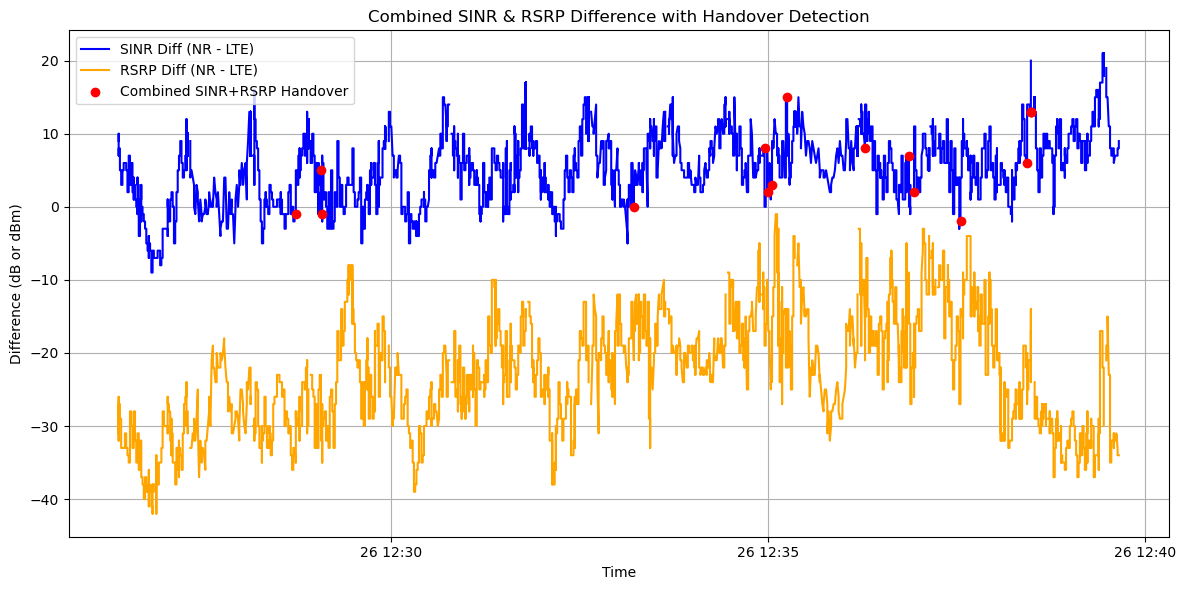

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate SINR and RSRP differences
df["SINR_Diff"] = df["NR_SINR"] - df["LTE_SINR"]
df["RSRP_Diff"] = df["NR_RSRP"] - df["LTE_RSRP"]

# Compute time-based difference for change detection
df["SINR_Change"] = df["SINR_Diff"].diff().abs()
df["RSRP_Change"] = df["RSRP_Diff"].diff().abs()

# Define joint threshold condition
combined_handover_points = df[(df["SINR_Change"] > 5) & (df["RSRP_Change"] > 6)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df["Time and date"], df["SINR_Diff"], label="SINR Diff (NR - LTE)", color='blue')
plt.plot(df["Time and date"], df["RSRP_Diff"], label="RSRP Diff (NR - LTE)", color='orange')

# Highlight combined handover triggers
plt.scatter(combined_handover_points["Time and date"], combined_handover_points["SINR_Diff"],
            color='red', label="Combined SINR+RSRP Handover", zorder=5)

plt.title("Combined SINR & RSRP Difference with Handover Detection")
plt.xlabel("Time")
plt.ylabel("Difference (dB or dBm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()